<a href="https://colab.research.google.com/github/radubelea/EmoDetect/blob/main/EmotionsKids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("hello")

hello


In [49]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
### CNN models ###
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.layers.normalization.batch_normalization import BatchNormalization
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

Parameters

In [126]:
batch_size = 32
num_epochs = 20
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
base_path = 'models/'
shape_x = 48
shape_y = 48
image_size=(48,48)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Data

In [114]:
data=pd.read_csv('/content/sample_data/fer2013/fer2013.csv')
data=data.head(500)

In [116]:
data['pixels']=data['pixels'].astype("string")
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.strip().split(' ',48*48)]
    if len(face) != 1537:
      face = np.asarray(face).reshape(width, height)
      face = cv2.resize(face.astype('uint8'),image_size)
      faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces /= 127.5
faces -= 1.
emotions = pd.get_dummies(data['emotion']).to_numpy()

In [117]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [118]:
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.3,shuffle=True)
xval,xtest,yval,ytest=train_test_split(xtest,ytest,test_size=0.3,shuffle=True)

CNN

In [119]:
def CNN():
    model = Sequential(name='CNN')
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    return model

In [120]:
CNN=CNN()

Training

In [121]:
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + 'CNN'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [122]:
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
CNN_history =CNN.fit(datagen.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xval,yval))

Epoch 1/20
10/10 [==============================] - 11s 892ms/step - loss: 2.4451 - accuracy: 0.1571 - val_loss: 1.9209 - val_accuracy: 0.1810

Epoch 00001: val_loss improved from inf to 1.92086, saving model to models/CNN.01-0.18.hdf5
Epoch 2/20
10/10 [==============================] - 9s 862ms/step - loss: 2.2099 - accuracy: 0.1686 - val_loss: 1.9398 - val_accuracy: 0.1619

Epoch 00002: val_loss did not improve from 1.92086
Epoch 3/20
10/10 [==============================] - 9s 868ms/step - loss: 1.9723 - accuracy: 0.2314 - val_loss: 1.9312 - val_accuracy: 0.1619

Epoch 00003: val_loss did not improve from 1.92086
Epoch 4/20
10/10 [==============================] - 10s 875ms/step - loss: 1.9163 - accuracy: 0.2686 - val_loss: 1.9504 - val_accuracy: 0.1619

Epoch 00004: val_loss did not improve from 1.92086
Epoch 5/20
10/10 [==============================] - 10s 872ms/step - loss: 1.9700 - accuracy: 0.1971 - val_loss: 1.9073 - val_accuracy: 0.1810

Epoch 00005: val_loss improved from 1

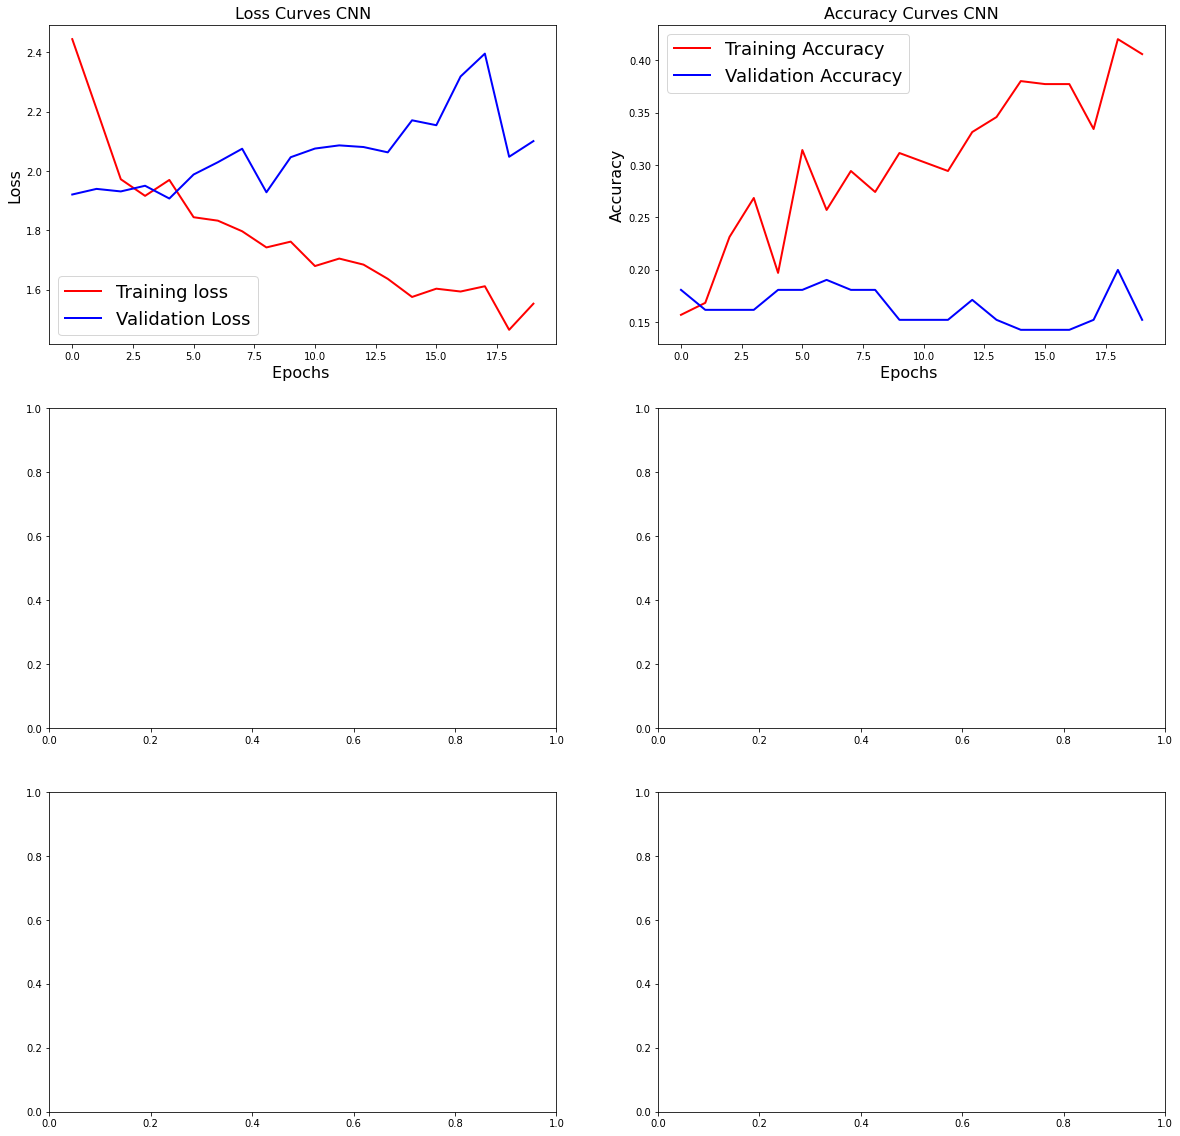

In [124]:
fig,axes=plt.subplots(3,2,figsize=(20, 20))
for (m,history), ax in zip({'CNN':CNN_history}.items(),axes):
    # Loss Curves
    
    ax[0].plot(history.history['loss'],'r',linewidth=2.0)
    ax[0].plot(history.history['val_loss'],'b',linewidth=2.0)
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Loss Curves '+m,fontsize=16)
 
    # Accuracy Curves
    ax[1].plot(history.history['accuracy'],'r',linewidth=2.0)
    ax[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Accuracy Curves '+m,fontsize=16)

In [125]:
  ypred=CNN.predict(xtest)
  ypred_=np.argmax(ypred, axis=1)
  ytest_=np.argmax(ytest, axis=1)
  print(classification_report(ytest_, ypred_,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         7
           1      0.000     0.000     0.000         1
           2      0.083     0.125     0.100         8
           3      0.556     0.500     0.526        10
           4      0.000     0.000     0.000        11
           5      0.000     0.000     0.000         5
           6      0.042     0.333     0.074         3

    accuracy                          0.156        45
   macro avg      0.097     0.137     0.100        45
weighted avg      0.141     0.156     0.140        45



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


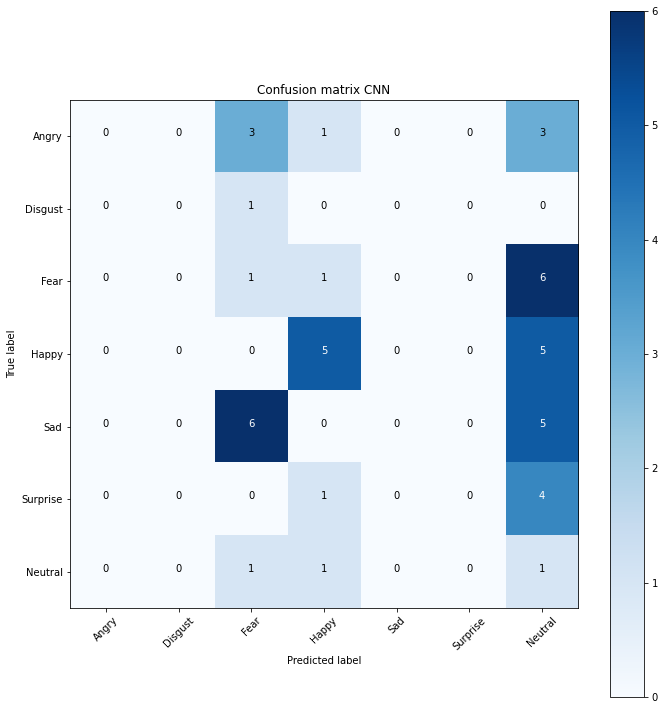

In [127]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure


fig = figure(figsize=(10, 10))
    
ypred=CNN.predict(xtest)
rounded_predections=np.argmax(ypred, axis=1)
rounded_labels=np.argmax(ytest, axis=1)
cm = confusion_matrix(rounded_labels, rounded_predections)
title='Confusion matrix '+CNN.name
    

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()